<h2><b>Customized Portfolio Back-testing for Central Deposit Insurance Corporation (CDIC)</b></h2>

In [5]:
import os
import warnings
warnings.filterwarnings('ignore')


import time
import pandas as pd
import numpy as np
from numpy import split
from numpy import array
from numpy import log
from numpy import zeros
from numpy import concatenate
from scipy import linalg

from matplotlib import pyplot as plt
from datetime import datetime
from math import sqrt

from pandas.tseries.offsets import BMonthEnd, BQuarterEnd, BMonthBegin, BQuarterBegin, BQuarterEnd, BDay
from pandas import read_csv, DataFrame, concat, datetime

import pyfolio as pf
import empyrical as ep
from scipy import stats

In [19]:
# import os
sCurrentWorkingDirectory = os.getcwd()
print('CurrentWorkingDirectory: ', sCurrentWorkingDirectory, '\n')
sDir = sCurrentWorkingDirectory

# load data
def parse(x):
    return datetime.strptime(x, '%Y/%m/%d')

# PW_data = read_csv('t50_price_weighting_rawdata.csv',  parse_dates = ['date'], date_parser=parse)
# earning_data = read_csv('earning_rawdata.csv',  parse_dates = ['date'], date_parser=parse)

return_data = read_csv('data.csv',  parse_dates = ['Date'], index_col=0, date_parser=parse)
# print('Length total: ',len(return_data)/12,' Years')
display(return_data.head())
display(return_data.tail())

CurrentWorkingDirectory:  D:\Jupyter\法人客戶投組 



,Balance
Date,
2017-10-03,1.000000e+07
2017-10-05,9.998090e+06
2017-10-06,1.004803e+07
2017-10-11,1.006210e+07
2017-10-12,1.007634e+07


,Balance
Date,
2019-06-25,10245757.24
2019-06-26,10218140.80
2019-06-27,10246496.90
2019-06-28,10241184.26
2019-07-01,10241184.26


In [7]:
year_list = ['2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019']
# return_data['2007']

Start date,2017-10-03
End date,2019-07-01
Total months,20
,Backtest
Annual return,1.4%
Cumulative returns,2.4%
Annual volatility,5.4%
Sharpe ratio,0.29
Calmar ratio,0.14
Stability,0.09
Max drawdown,-10.2%


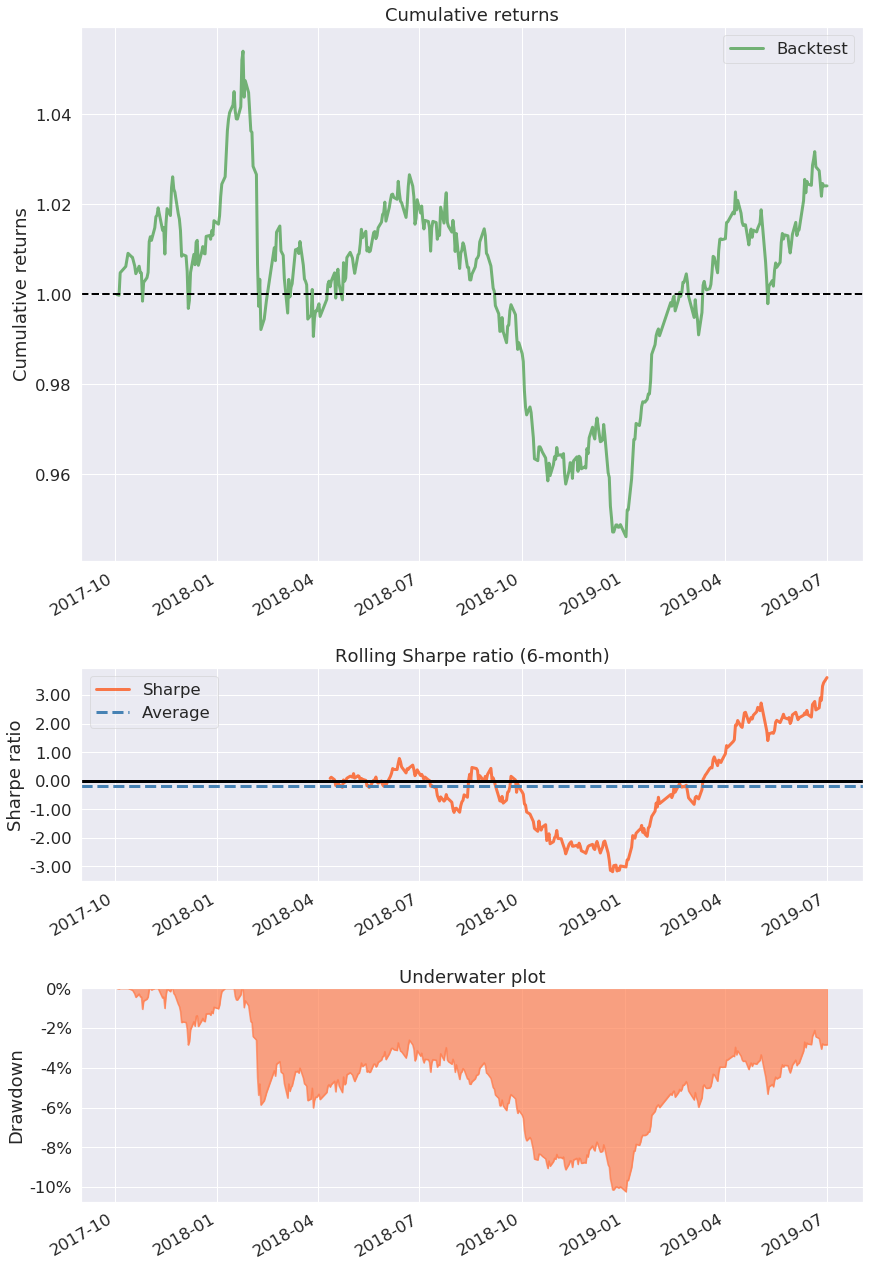

In [20]:
def ln_return(series):
    #calculate natural log return
    ln_rts = lambda y,x: (y-x)/x
    series = ln_rts(series,series.shift(1))
    return series


# return_data.index = pd.to_datetime(return_data.index).tz_localize('UTC')

# report the stats and tear sheets
# perf_list = []

df = ln_return(return_data)
df = df.iloc[:,0]

ess_sharpe(df,df2),index=['Information ratio'])
# stats_sheet = DataFrame(pf.timeseries.perf_stats(df,df2).append(info_ratio))
# perf_list.append(stats_sheet)
# display(stats_sheet)
# pf.create_simple_tear_sheet(df)
# pf.create_full_tear_sheet(df)

pf.create_simple_tear_sheet(df)

In [122]:
#find  matplotlib default font
# from matplotlib.font_manager import findfont, FontProperties  
# findfont(FontProperties(family=FontProperties().get_family())) 
myfont = FontProperties(fname=r'msj.ttf')
myfont

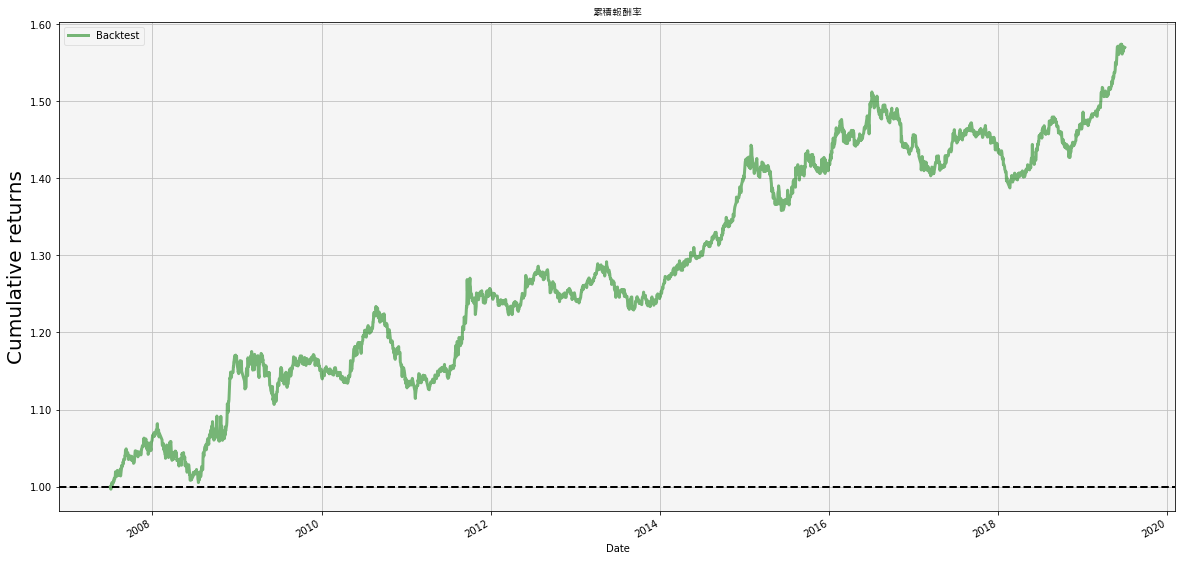

In [126]:
def plot_rolling_returns(returns,
                         factor_returns=None,
                         live_start_date=None,
                         logy=False,
                         cone_std=None,
                         legend_loc='best',
                         volatility_match=False,
                         cone_function=pf.timeseries.forecast_cone_bootstrap,
                         ax=None, **kwargs):
    plt.rcParams['axes.facecolor'] = '#F5F5F5'
#     plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
    plt.figure(figsize=(20,10))

    if ax is None:
        ax = plt.gca()

    ax.set_xlabel('')
    ax.set_ylabel('Cumulative returns', fontsize=20)
    ax.set_yscale('log' if logy else 'linear')

    if volatility_match and factor_returns is None:
        raise ValueError('volatility_match requires passing of '
                         'factor_returns.')
    elif volatility_match and factor_returns is not None:
        bmark_vol = factor_returns.loc[returns.index].std()
        returns = (returns / returns.std()) * bmark_vol

    cum_rets = ep.cum_returns(returns, 1.0)

    y_axis_formatter = FuncFormatter(pf.utils.two_dec_places)
    ax.yaxis.set_major_formatter(FuncFormatter(y_axis_formatter))

    if factor_returns is not None:
        cum_factor_returns = ep.cum_returns(
            factor_returns[cum_rets.index], 1.0)
        cum_factor_returns.plot(lw=2, color='gray',
                                label=factor_returns.name, alpha=0.60,
                                ax=ax, **kwargs)

    if live_start_date is not None:
        live_start_date = ep.utils.get_utc_timestamp(live_start_date)
        is_cum_returns = cum_rets.loc[cum_rets.index < live_start_date]
        oos_cum_returns = cum_rets.loc[cum_rets.index >= live_start_date]
    else:
        is_cum_returns = cum_rets
        oos_cum_returns = pd.Series([])

    is_cum_returns.plot(lw=3, color='forestgreen', alpha=0.6,
                        label='Backtest', ax=ax, **kwargs)

    if len(oos_cum_returns) > 0:
        oos_cum_returns.plot(lw=4, color='red', alpha=0.6,
                             label='Live', ax=ax, **kwargs)

        if cone_std is not None:
            if isinstance(cone_std, (float, int)):
                cone_std = [cone_std]

            is_returns = returns.loc[returns.index < live_start_date]
            cone_bounds = cone_function(
                is_returns,
                len(oos_cum_returns),
                cone_std=cone_std,
                starting_value=is_cum_returns[-1])

            cone_bounds = cone_bounds.set_index(oos_cum_returns.index)
            for std in cone_std:
                ax.fill_between(cone_bounds.index,
                                cone_bounds[float(std)],
                                cone_bounds[float(-std)],
                                color='steelblue', alpha=0.5)

    if legend_loc is not None:
        ax.legend(loc=legend_loc, frameon=True, framealpha=0.5)
    ax.axhline(1.0, linestyle='--', color='black', lw=2)
    ax.grid(True, color = "silver")
    ax.set_title('累積報酬率', fontproperties = myfont , fontsize=40)
    return ax

plot_rolling_returns(df)
plt.savefig('cumulative return.png')

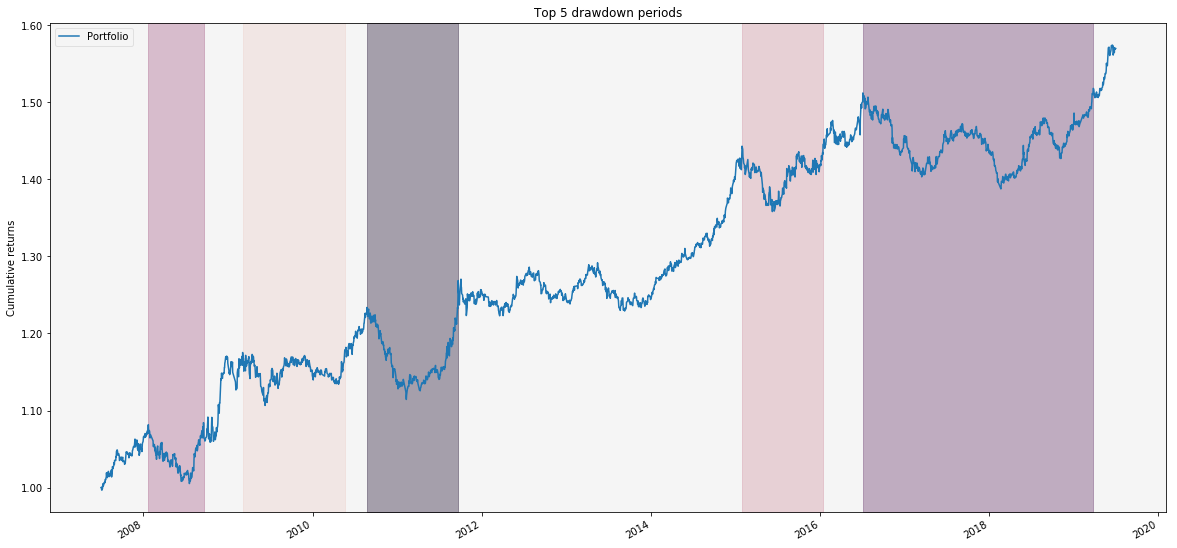

In [96]:
def plot_drawdown_periods(returns, top=5, ax=None, **kwargs):
    plt.figure(figsize=(20,10))
    
    if ax is None:
        ax = plt.gca()

    y_axis_formatter = FuncFormatter(pf.utils.two_dec_places)
    ax.yaxis.set_major_formatter(FuncFormatter(y_axis_formatter))

    df_cum_rets = ep.cum_returns(returns, starting_value=1.0)
    df_drawdowns = pf.timeseries.gen_drawdown_table(returns, top=top)

    df_cum_rets.plot(ax=ax, **kwargs)

    lim = ax.get_ylim()
    colors = sns.cubehelix_palette(len(df_drawdowns))[::-1]
    for i, (peak, recovery) in df_drawdowns[
            ['Peak date', 'Recovery date']].iterrows():
        if pd.isnull(recovery):
            recovery = returns.index[-1]
        ax.fill_between((peak, recovery),
                        lim[0],
                        lim[1],
                        alpha=.4,
                        color=colors[i])
    ax.set_ylim(lim)
    ax.set_title('Top %i drawdown periods' % top, fontsize=20)
    ax.set_ylabel('Cumulative returns', fontsize=20)
    ax.legend(['Portfolio'], loc='upper left',
              frameon=True, framealpha=0.5)
    ax.set_xlabel('')
#     ax.grid(True, color = "gray")
    return ax

plot_drawdown_periods(df)
plt.savefig('drawdown.png')

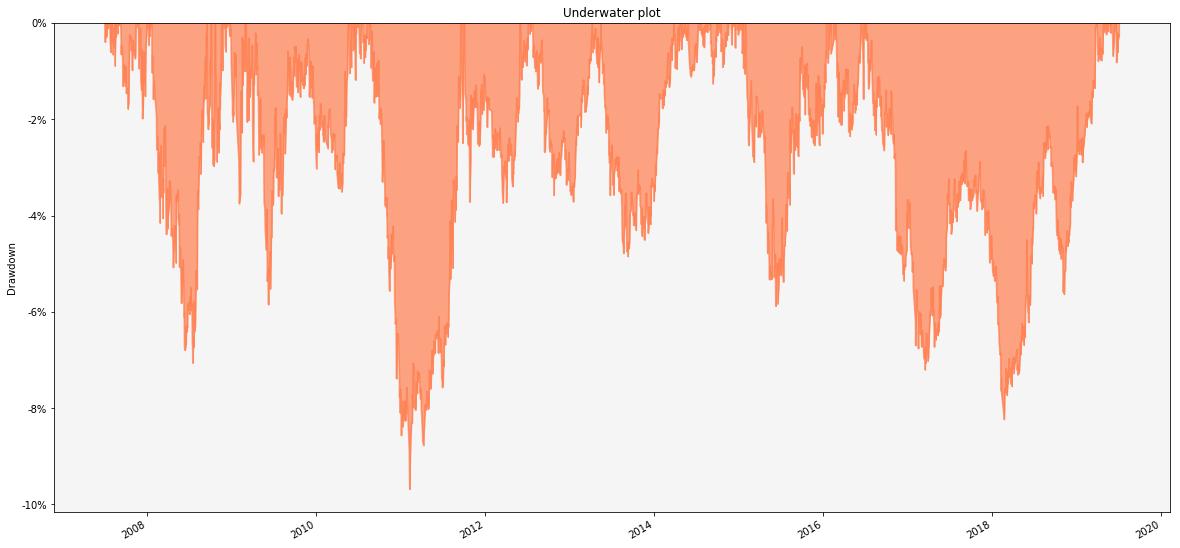

In [97]:
def plot_drawdown_underwater(returns, ax=None, **kwargs):
    plt.figure(figsize=(20,10))
    
    if ax is None:
        ax = plt.gca()

    y_axis_formatter = FuncFormatter(pf.utils.percentage)
    ax.yaxis.set_major_formatter(FuncFormatter(y_axis_formatter))

    df_cum_rets = ep.cum_returns(returns, starting_value=1.0)
    running_max = np.maximum.accumulate(df_cum_rets)
    underwater = -100 * ((running_max - df_cum_rets) / running_max)
    (underwater).plot(ax=ax, kind='area', color='coral', alpha=0.7, **kwargs)
    ax.set_ylabel('Drawdown')
    ax.set_title('Underwater plot')
    ax.set_xlabel('')
#     ax.grid(True, color = "gray")
    return ax

plot_drawdown_underwater(df)
plt.savefig('underwater.png')

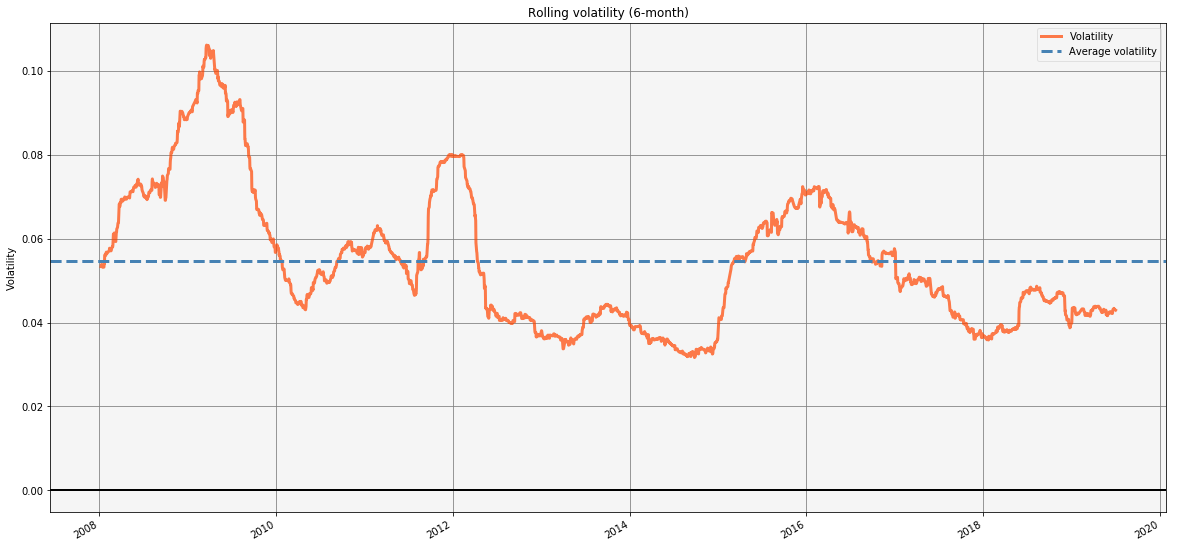

In [98]:
def plot_rolling_volatility(returns, factor_returns=None,
                            rolling_window=22 * 6,
                            legend_loc='best', ax=None, **kwargs):
    
    plt.figure(figsize=(20,10))
    
            
    if ax is None:
        ax = plt.gca()

    y_axis_formatter = FuncFormatter(pf.utils.two_dec_places)
    ax.yaxis.set_major_formatter(FuncFormatter(y_axis_formatter))

    rolling_vol_ts = pf.timeseries.rolling_volatility(
        returns, rolling_window)
    rolling_vol_ts.plot(alpha=.7, lw=3, color='orangered', ax=ax,
                        **kwargs)
    if factor_returns is not None:
        rolling_vol_ts_factor = timeseries.rolling_volatility(
            factor_returns, rolling_window)
        rolling_vol_ts_factor.plot(alpha=.7, lw=3, color='grey', ax=ax,
                                   **kwargs)

    ax.set_title('Rolling volatility (6-month)')
    ax.axhline(
        rolling_vol_ts.mean(),
        color='steelblue',
        linestyle='--',
        lw=3)

    ax.axhline(0.0, color='black', linestyle='-', lw=2)

    ax.set_ylabel('Volatility')
    ax.set_xlabel('')
    if factor_returns is None:
        ax.legend(['Volatility', 'Average volatility'],
                  loc=legend_loc, frameon=True, framealpha=0.5)
    else:
        ax.legend(['Volatility', 'Benchmark volatility', 'Average volatility'],
                  loc=legend_loc, frameon=True, framealpha=0.5)
    
    ax.grid(True, color = "gray")

    return ax

# ax_rolling_volatility = plt.subplot(gs[i, :], sharex=ax_rolling_returns)

plot_rolling_volatility(df)
plt.savefig('Annual_volatility.png')

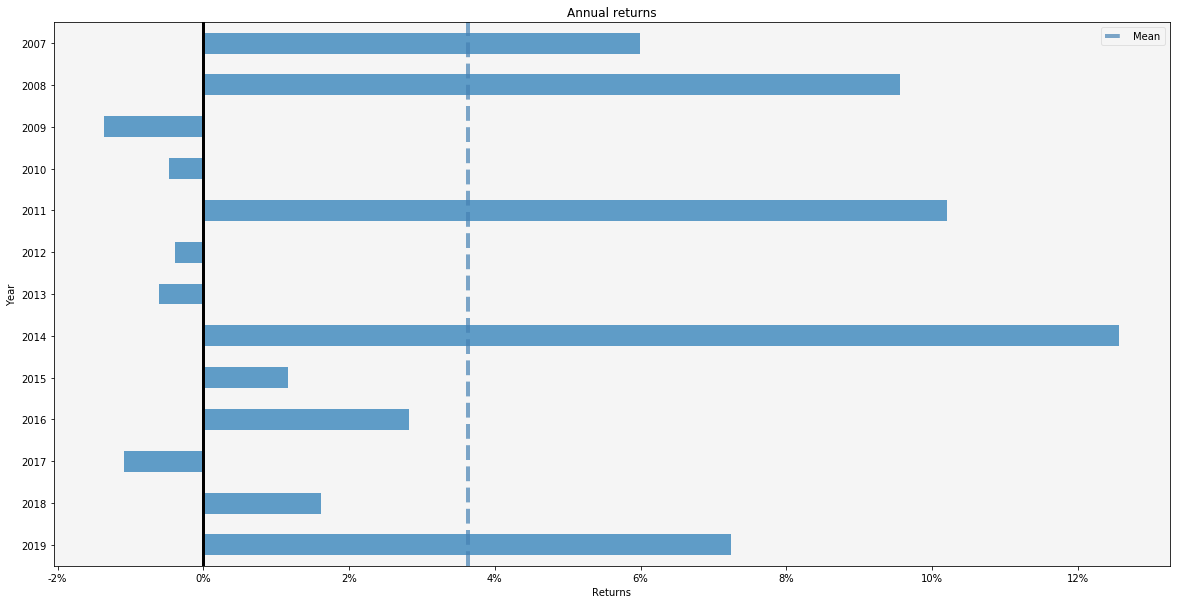

In [99]:

def plot_annual_returns(returns, ax=None, **kwargs):
    plt.figure(figsize=(20,10))
    
    if ax is None:
        ax = plt.gca()
        
#     rect = plt.Rectangle((0,0),1.5,0.9)
#     ax.add_patch(rect)
        
    x_axis_formatter = FuncFormatter(pf.utils.percentage)
    ax.xaxis.set_major_formatter(FuncFormatter(x_axis_formatter))
    ax.tick_params(axis='x', which='major')
        
    ann_ret_df = pd.DataFrame(
        ep.aggregate_returns(
            returns,
            'yearly'))

    ax.axvline(
        100 *
        ann_ret_df.values.mean(),
        color='steelblue',
        linestyle='--',
        lw=4,
        alpha=0.7)
    (100 * ann_ret_df.sort_index(ascending=False)
     ).plot(ax=ax, kind='barh', alpha=.70, **kwargs)
    ax.axvline(0.0, color='black', linestyle='-', lw=3)

    ax.set_ylabel('Year')
    ax.set_xlabel('Returns')
    ax.set_title("Annual returns")
    ax.legend(['Mean'], frameon=True, framealpha=0.5)
    return ax

plot_annual_returns(df)

# pf.plotting.plot_annual_returns(df)
plt.savefig('Annual_returns.png')

In [92]:
ep.aggregate_returns(df,'yearly')

2007    0.059924
2008    0.095548
2009   -0.013597
2010   -0.004683
2011    0.102062
2012   -0.003873
2013   -0.006057
2014    0.125638
2015    0.011633
2016    0.028284
2017   -0.010906
2018    0.016136
2019    0.072400
Name: Balance, dtype: float64